<a href="https://colab.research.google.com/github/surajn28/NMA-Transfer_Learning/blob/main/Transfer_learning_FER_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import ResNet model







In [21]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import os.path as osp
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset,DataLoader
class BasicBlock(nn.Module):
  """ResNet in PyTorch.
      Reference:
      [1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
        Deep Residual Learning for Image Recognition. arXiv:1512.03385
  """

  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out


class Bottleneck(nn.Module):
  expansion = 4

  def __init__(self, in_planes, planes, stride=1):
    super(Bottleneck, self).__init__()
    self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(self.expansion*planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion*planes:
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out


class ResNet(nn.Module):
  def __init__(self, block, num_blocks, num_classes=2):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    # out = F.avg_pool2d(out, 4)
    out = self.avgpool(out)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out


def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
  return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
  return ResNet(Bottleneck, [3, 4, 6, 3])



# if __name__ == "__main__":

#     path = '/Users/gaojun/Documents/p1/NMA/FERG_DB_256'
#     trainset = HDF5Dataset(osp.join(path,'train.h5'))
#     testset = HDF5Dataset(osp.join(path,'test.h5'))

#     trainloader = DataLoader(trainset, batch_size=12, shuffle=True)
#     testloader = DataLoader(testset, batch_size=12, shuffle=True)

#     net = ResNet18()
#     net = net.double()
#     t = torch.tensor(trainset.__getitem__(1)[0]).unsqueeze(dim=0).to(torch.double)

#     y = net(t)
#     print(y)



In [22]:
import os 
os.chdir(r'C:\Users\wliwa\Desktop\drive')

In [23]:
# imports
import gc
import csv
import glob
import torch
import pandas as pd
import PIL
import h5py
import multiprocessing

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

# from google.colab import drive
# from ResNet import ResNet,BasicBlock,Bottleneck

# Class H5FileDataset


In [24]:
# Data loader with data augmentation

class H5FileDataset(Dataset):
    # dataloader output: (pic_indices, color_channel, height, width)
    def __init__(self, h5_filename, transform=None, target_transform=None):
        self.h5_filename = h5_filename
        self.img_h5_file = self._load_h5_file(self.h5_filename)
        self.all_labels = self.img_h5_file['labels'][:]
        self.transform = transform  # it just assign the "state" of transform, not apply it


    def __len__(self):
        return len(self.all_labels)


    def __getitem__(self, idx):
        img = self.img_h5_file['img_data'][idx]
        label = self.img_h5_file['labels'][idx]

        label = torch.as_tensor(label, dtype=torch.float64)

        img = np.transpose(img, [2, 0, 1])
        img = img.astype(np.double)
        img = torch.as_tensor(img, dtype=torch.float64)
        img = img/255
        if self.transform is not None:
            img = self.transform(img)  # we're going to write specific methods for transform
        return img, label


    def _load_h5_file(self, h5_filename):
        file = h5py.File(h5_filename, 'r')
        img_data = file['pic_mat']
        img_labels = file['labels']
        return dict(file=file, img_data=img_data, labels=img_labels)



# Define Training and testing function

In [25]:
def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])

# hyper-parameters
use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
batch_size = 64
max_epochs = 15  # Please change this to 200
max_epochs_target = 10
# base_learning_rate = 0.5

base_learning_rate = 0.1

torchvision_transforms = True  # True/False if you want use torchvision augmentations

def train(net, epoch, trainloader, use_cuda=True):
  print('\nEpoch: %d' % epoch)
  net.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
    print('batch_idx ', batch_idx)
    targets = np.array(targets, dtype=int)
    # targets_num = np.zeros(len(targets))
    # print(targets_num.shape)
    # for idx_target in range(len(targets)):
    #   if targets[idx_target] == 'joy':
    #     targets_num[idx_target] = 0
    #   else:
    #     targets_num[idx_target] = 1
    targets = torch.as_tensor(targets, dtype=torch.long)
    if use_cuda:
      inputs, targets = inputs.cuda(), targets.cuda()
    print('converted targets', batch_idx)

    optimizer.zero_grad()
    inputs, targets = Variable(inputs), Variable(targets)
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    print('optimizer ', batch_idx)

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += predicted.eq(targets.data).cpu().sum()
    print('correct ', batch_idx)

    # if batch_idx % 500 == 0:
    print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
      
  return (train_loss/batch_idx, 100.*correct/total)


def test(net, epoch, testloader, outModelName, use_cuda=True):
  global best_acc
  net.eval()
  test_loss, correct, total = 0, 0, 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
      print('batch_idx ', batch_idx)
      targets = np.array(targets, dtype=int)
      # targets_num = np.zeros(len(targets))
      # print(targets_num.shape)
      # for idx_target in range(len(targets)):
      #   if targets[idx_target] == 'joy':
      #     targets_num[idx_target] = 0
      #   else:
      #     targets_num[idx_target] = 1
      targets = torch.as_tensor(targets, dtype=torch.long)
      print('converted targets', batch_idx)
      if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

      outputs = net(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += predicted.eq(targets.data).cpu().sum()

      if batch_idx % 200 == 0:
        print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        best_acc = acc
        checkpoint(net, acc, epoch, outModelName)
    return (test_loss/batch_idx, 100.*correct/total)

# checkpoint & adjust_learning_rate
def checkpoint(model, acc, epoch, outModelName):
  # Save checkpoint.
  print('Saving..')
  state = {
      'state_dict': model.state_dict(),
      'acc': acc,
      'epoch': epoch,
      'rng_state': torch.get_rng_state()
  }
  if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')
  torch.save(state, f'./checkpoint/{outModelName}.t7')

def adjust_learning_rate(optimizer, epoch):
  """decrease the learning rate at 100 and 150 epoch"""
  lr = base_learning_rate
  if epoch <= 9 and lr > 0.1:
    # warm-up training for large minibatch
    lr = 0.1 + (base_learning_rate - 0.1) * epoch / 10.
  if epoch >= 100:
    lr /= 10
  if epoch >= 150:
    lr /= 10
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

# if __name__=="__main__":


In [26]:
print(use_cuda)

True


# DataLoader

## FERG set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch size: torch.Size([64, 3, 128, 128])


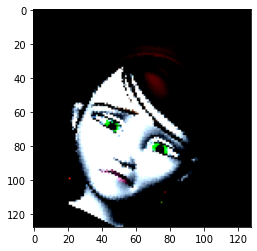

Text(0.5, 0.98, 'label 1.0')

<Figure size 432x288 with 0 Axes>

In [27]:
# composed = transforms.Compose([transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# mean and std calc from calc_normalization.py from wanru-legion, all used FERG data
composed = transforms.Compose([transforms.RandomRotation(30),
                               transforms.Normalize([0.20473262, 0.14647761, 0.11153657],
                                                    [0.27463099, 0.20145596, 0.16454244])])

trainset = H5FileDataset(r'C:\Users\wliwa\Desktop\drive\datasets\FERG_h5\new\train_dataset.h5',
                         transform=composed)
testset = H5FileDataset(r'C:\Users\wliwa\Desktop\drive\datasets\FERG_h5\new\test_dataset.h5',
                        transform=composed)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)


batch_images, batch_labels = next(iter(trainloader))
print('Batch size:', batch_images.shape)
eg_pic = batch_images[0]
eg_label = batch_labels[0]
plt.figure()
plt.imshow(eg_pic.permute([1, 2, 0]))
plt.show()
plt.suptitle(f'label {eg_label}')


## KDEF set

In [28]:
# path = '../../datasets/KDEF_h5/new'

# # composed = transforms.Compose([transforms.RandomCrop([500, 500]), 
# #                                transforms.Resize([128, 128]), 
# #                                transforms.RandomRotation(30), 
# #                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# train_dataset = H5FileDataset(os.path.join(path,'kdef_train_dataset.h5'),
#                              transform=composed)
# val_dataset = H5FileDataset(os.path.join(path,'kdef_val_dataset.h5'),
#                              transform=composed)
# test_dataset = H5FileDataset(os.path.join(path,'kdef_test_dataset.h5'),
#                              transform=composed)

# train_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=True)
# batch_images, batch_labels = next(iter(train_dataloader))
# print('Batch size:', batch_images.shape)

# plt.figure()
# plt.imshow(batch_images[6].permute([1, 2, 0]).to(torch.uint8))
# plt.show()
# plt.suptitle(f'label {batch_labels[0]}')

# print(batch_images[6].mean())

# Main 

In [29]:
# mean and std calc from calc_normalization.py from wanru-legion, all used FERG data
composed = transforms.Compose([transforms.RandomRotation(30),
                               transforms.Normalize([0.20473262, 0.14647761, 0.11153657],
                                                    [0.27463099, 0.20145596, 0.16454244])])


In [ ]:
net = ResNet18()
net = net.double()
net = net.cuda()
result_folder = './results/'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

logname = result_folder + net.__class__.__name__ + '_pretrain' + '.csv'

# Optimizer and criterion
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=base_learning_rate, momentum=0.9, weight_decay=1e-4)

outModelName = 'pretrain'
if not os.path.exists(logname):
    with open(logname, 'w') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow(['epoch', 'train loss', 'train acc', 'test loss', 'test acc'])

for epoch in range(start_epoch, max_epochs):
    adjust_learning_rate(optimizer, epoch)

    trainset = H5FileDataset(r'C:\Users\wliwa\Desktop\drive\datasets\FERG_h5\new\train_dataset.h5',
                             transform=composed)
    testset = H5FileDataset(r'C:\Users\wliwa\Desktop\drive\datasets\FERG_h5\new\test_dataset.h5',
                            transform=composed)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
    
    train_loss, train_acc = train(net, epoch, trainloader, use_cuda=use_cuda)
    print('finished train epoch ', epoch)
    test_loss, test_acc = test(net, epoch, testloader, outModelName, use_cuda=use_cuda)
    print('finished test epoch ', epoch)
    with open(logname, 'a') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow([epoch, train_loss, train_acc.item(), test_loss, test_acc.item()])
    print(f'Epoch: {epoch} | train acc: {train_acc} | test acc: {test_acc}')


Epoch: 0
batch_idx  0
converted targets 0
optimizer  0
correct  0
0 38 Loss: 0.667 | Acc: 60.938% (39/64)
batch_idx  1
converted targets 1
optimizer  1
correct  1
1 38 Loss: 0.847 | Acc: 51.562% (66/128)
batch_idx  2
converted targets 2
optimizer  2
correct  2
2 38 Loss: 3.343 | Acc: 51.562% (99/192)
batch_idx  3
converted targets 3
optimizer  3
correct  3
3 38 Loss: 3.589 | Acc: 50.391% (129/256)
batch_idx  4
converted targets 4
optimizer  4
correct  4
4 38 Loss: 3.984 | Acc: 49.375% (158/320)
batch_idx  5
converted targets 5
optimizer  5
correct  5
5 38 Loss: 3.870 | Acc: 50.260% (193/384)
batch_idx  6
converted targets 6
optimizer  6
